In [1]:
import numpy as np
import requests, gzip, os, hashlib
%pylab inline
import pickle
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [2]:
#fetch data
path='data'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:59900]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]
X_train.shape = (X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_val.shape = (X_val.shape[0],X_val.shape[1]*X_val.shape[2])

In [ ]:
i = 0
k = 0
v = []
for j in [1000,1000,1000,500,500,500,200,200,200,100,100,100,50,50,50]:#[20000, 10000, 10000, 5000, 5000, 2000, 2000, 1000, 1000]:
    clf = LogisticRegression()
    k+=j
    print(X_train[i:k,:].shape)
    clf.fit(X_train[i:k,:], Y_train[i:k])
    predictions = clf.predict(X_val)
    i+=j
    v.append(predictions)
    print(np.mean(predictions == Y_val))

In [68]:
v = np.array(v)

In [69]:
v.shape

(15, 100)

In [70]:
v = v.transpose()

In [71]:
votes = []
target = []
for i in range(len(v)):
    answers=[]
    for j in range(len(v[0])):
        if not(v[i][j] in answers):
            answers.append(v[i][j])
    for answer in answers:
        temp = np.array([answer]*len(v[0]))
        votes.append(1*(v[i]==temp)-1*(v[i]!=temp)) 
        if answer == Y_val[i]:
            target.append(1)
        else:
            target.append(0)
            
votes = np.array(votes)
target = np.array(target)

print(votes.shape) #The new matrix of votes 
print(target.shape) #The new matrix of answers

(250, 15)
(250,)


In [72]:
#Classic voting error:

answers = (np.sum(votes,1)>0)
answers.shape = target.shape
print('error percentage and number of errors with classic vote:')
print(np.mean(np.abs(answers!=target)), np.sum(np.abs(answers!=target)))

#SAME AS PAPER

error percentage and number of errors with classic vote:
0.088 22


In [73]:
def est3(v, iterations, target):
    nq, nv = v.shape
    trust = 0.1* np.ones((1, nv))  # voters trustworthiness
    diff = 0.1*np.ones((nq, 1))  # queries difficulty
    target.shape = (nq, 1)
    error = [] # We will measure the error on each iteration to track it
    
    t = (v==1)
    t_ = (v==-1)
    
    for it in range(iterations):
        n = np.sum(t,1) + np.sum(t_,1)
        pos = np.sum(t * (1 - np.matmul(diff, trust)), 1)
        neg = np.sum(t_ * np.matmul(diff, trust), 1)
        y = (pos + neg) / n
        y.shape = (nq, 1)
        
        n = np.sum(t,1)+np.sum(t_,1)
        pos = np.sum(t  * np.matmul((1 - y), 1 / trust), 1)
        neg = np.sum(t_ * np.matmul(y, 1 / trust), 1)
        diff = (pos + neg) / n
        diff.shape = (nq, 1)

        n = np.sum(t,0) + np.sum(t_,0)
        pos = np.matmul(t.transpose(), (1 - y) / diff)
        neg = np.matmul(t_.transpose(), y / diff)
        n.shape = pos.shape
        trust = (pos + neg) / n
        trust.shape = (1, nv)
        
        error.append(np.mean((np.array(y)>=0.5)!=target)) # % of votes that are wrong
        
    return np.array(y), np.array(trust), np.array(diff), error

In [74]:
#Testing on hubdub
y = est3(votes,10,target)

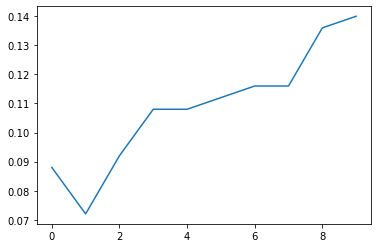

Error percentage on last iteration:  0.14
The minimum number of errors was achieved on iteration number  2  and it had  10.511999999999999  errors.


In [75]:
plt.plot(y[-1])
plt.show() # % of errors on each iteration.
print('Error percentage on last iteration: ', y[-1][-1])
print('The minimum number of errors was achieved on iteration number ', np.argmin(y[-1])+1, ' and it had ', 146*np.min(y[-1]), ' errors.')

In [99]:
def cosine(votes, iterations, target):
    v = votes.transpose()
    t = (v==1)
    t_ = (v==-1)
    nv, nq = v.shape
    error = []
    N = np.sum(v**2, 1) # Number of {votes!=0}
    trust = (np.sum(t, 1) - np.sum(t_, 1))/ N
    trust.shape = (nv, 1)
    N.shape = trust.shape
    y = np.ones((nq,1))
    target.shape = y.shape
    error.append(np.mean(np.abs(target - (y> 0))))
    eta = 0.2
    
    for iteration in range(iterations):
        pos = np.matmul(t,y)
        neg = np.matmul(t_,y)
        norm = np.matmul(v**2,y**2)*N
        print(np.min(norm), np.max(norm))
        norm = np.sqrt(norm)
        new_trust = (pos - neg)/norm
        trust = trust*(1-eta) + new_trust*eta
    
        k = np.matmul(v.transpose(), trust)
        norm = np.matmul((v**2).transpose(), trust)
        print('---', np.min(norm**2), np.max(norm**2))
        y = (k*norm) / (norm**2)
        error.append(np.mean(np.abs(target - (y>0))))
        
    return y, error

62500.0 62500.0
--- 9.000000000000004 9.000000000000004
33513.3333333333 33513.33333333333
--- 0.041291187187289045 0.041291187187289045
25975.469715241066 25975.46971524108
--- 2.3863673549905915 2.386367354990593
34880.92646781678 34880.92646781678
--- 11.774888071895754 11.774888071895754
35396.37378765677 35396.37378765678
--- 24.401862569016167 24.401862569016167
35555.19709060833 35555.19709060834
--- 37.774587550744165 37.774587550744165
35632.988117338355 35632.988117338355
--- 50.564980284971945 50.564980284971945
35679.00568634324 35679.005686343255
--- 62.135565460911714 62.135565460911714
35709.15747868674 35709.15747868675
--- 72.2480485082752 72.2480485082752
35730.20066365982 35730.20066365984
--- 80.88555408513591 80.88555408513591


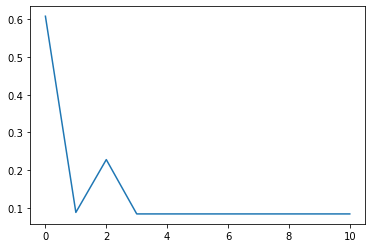

Error percentage on last iteration:  0.084 12.264000000000001
The minimum number of errors was achieved on iteration number  4  and it had  12.264000000000001  errors.


In [100]:
y = cosine(votes,10,target)
plt.plot(y[-1])
plt.show() # % of errors on each iteration.
print('Error percentage on last iteration: ', y[-1][-1], y[-1][-1]*146)
print('The minimum number of errors was achieved on iteration number ', np.argmin(y[-1])+1, ' and it had ', 146*np.min(y[-1]), ' errors.')

In [90]:
def map_to_ring(x):
    a = 2**20
    a = a * x
    a = np.rint(a)
    a = a.astype(int)
    a = a % 2**60
    return a

def secret_share(x, real=True, modulo=False):
    if not modulo:
        modulo = 2**60
    if real:
        x = map_to_ring(x)
    shares_partner = np.random.randint(0, modulo, x.shape)
    pickle.dump(shares_partner, open('mnist.alice', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    shares_identity = (x - shares_partner).astype(int) % modulo
    pickle.dump(shares_identity, open('mnist.bob', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)


In [93]:
secret_share(votes)

In [94]:
pickle.dump(target, open('mnist.target', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)